In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_percentage_error as mape
    
)
from statsforecast import StatsForecast

from statsforecast.models import (
    AutoARIMA,
    HistoricAverage,
    RandomWalkWithDrift,
    HoltWinters,
    DynamicOptimizedTheta
)

## Biblioteca base

- Aqui, será usado com base a biblioteca [statsforecast](https://nixtla.github.io/statsforecast/), a qual fornece métodos importantes e de fácil utilização para avaliação de multiplas séries temporais, além de diversos modelos em seu catálogo.

## Métricas de avaliação

Como métricas de avaliação, utilizaremos a Root Mean Squared Error (RMSE) e Mean Absolut Percentage Error (MAPE)

### Root Mean Squared Error

$\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$


- O RMSE é a raiz quadrada da média dos erros quadrados entre os valores previstos e reais.
- Devido à elevação ao quadrado, o RMSE é mais sensível a valores discrepantes do que o MAPE, tendo como intuito de utilização justamente observar erros mais discrepantes, além da distribuição dos mesmos, pois estão na mesma unidade de medida dos valores reais.
- Quanto mais próximo de zero o RMSE, melhor o desempenho do modelo.

### Mean Absolut Percentage Error

$\frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100$


- O MAPE é uma média de diferenças percentuais absolutas entre os valores previstos e reais.
- É expresso como uma porcentagem, tornando fácil de entender e comparar com os valores da base de dados.
- O MAPE é menos sensível a valores discrepantes do que o RMSE, no entanto, pode ser problemático quando os valores reais estão próximos de zero ou quando há valores extremos nos dados, pois devido à divisão, os resultados podem explodir.


## Leitura e ajuste dos dados

In [31]:
df = pd.read_csv("../Dados/model_input.csv")

In [104]:
y_df = pd.read_csv("../Dados/Y.csv")

In [32]:
df.head()

,Unnamed: 0,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,1980,0.123529,2.7,-5.4,2.945455,2.4,8.2,0.7,-0.04,3.795347,...,-0.8,3.3,1.417539,1.8,6.4,0.9,-1.9,3.8,3.9,2.1
1,1981,1.823529,5.7,3.0,3.345455,-4.4,3.8,-5.7,1.66,3.214077,...,-0.5,1.9,0.047214,0.1,0.9,2.0,-0.2,4.2,3.9,1.9
2,1982,2.423529,2.9,6.4,1.345455,0.0,-0.1,-3.1,2.26,3.658083,...,1.4,1.5,0.705273,0.6,-0.5,-0.1,0.4,2.2,3.9,0.7
3,1983,2.723529,1.1,5.4,3.145455,4.2,5.4,3.7,2.56,3.600038,...,4.6,1.8,1.417539,1.7,-2.8,3.3,0.7,4.0,3.9,2.6
4,1984,2.323529,2.0,5.6,5.745455,6.0,10.2,2.0,2.16,5.217868,...,4.1,4.1,2.013396,2.5,3.9,5.0,0.3,6.6,3.9,4.6


In [33]:
df = df.rename(columns={"Unnamed: 0": "ds"})
df.head()

,ds,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,1980,0.123529,2.7,-5.4,2.945455,2.4,8.2,0.7,-0.04,3.795347,...,-0.8,3.3,1.417539,1.8,6.4,0.9,-1.9,3.8,3.9,2.1
1,1981,1.823529,5.7,3.0,3.345455,-4.4,3.8,-5.7,1.66,3.214077,...,-0.5,1.9,0.047214,0.1,0.9,2.0,-0.2,4.2,3.9,1.9
2,1982,2.423529,2.9,6.4,1.345455,0.0,-0.1,-3.1,2.26,3.658083,...,1.4,1.5,0.705273,0.6,-0.5,-0.1,0.4,2.2,3.9,0.7
3,1983,2.723529,1.1,5.4,3.145455,4.2,5.4,3.7,2.56,3.600038,...,4.6,1.8,1.417539,1.7,-2.8,3.3,0.7,4.0,3.9,2.6
4,1984,2.323529,2.0,5.6,5.745455,6.0,10.2,2.0,2.16,5.217868,...,4.1,4.1,2.013396,2.5,3.9,5.0,0.3,6.6,3.9,4.6


In [34]:
df_train = df[df["ds"] <= 2023]
df_train

,ds,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,1980,0.123529,2.7,-5.4,2.945455,2.4,8.2,0.7,-0.04,3.795347,...,-0.8,3.3,1.417539,1.8,6.4,0.9,-1.9,3.8,3.9,2.1
1,1981,1.823529,5.7,3.0,3.345455,-4.4,3.8,-5.7,1.66,3.214077,...,-0.5,1.9,0.047214,0.1,0.9,2.0,-0.2,4.2,3.9,1.9
2,1982,2.423529,2.9,6.4,1.345455,0.0,-0.1,-3.1,2.26,3.658083,...,1.4,1.5,0.705273,0.6,-0.5,-0.1,0.4,2.2,3.9,0.7
3,1983,2.723529,1.1,5.4,3.145455,4.2,5.4,3.7,2.56,3.600038,...,4.6,1.8,1.417539,1.7,-2.8,3.3,0.7,4.0,3.9,2.6
4,1984,2.323529,2.0,5.6,5.745455,6.0,10.2,2.0,2.16,5.217868,...,4.1,4.1,2.013396,2.5,3.9,5.0,0.3,6.6,3.9,4.6
5,1985,3.223529,-1.5,5.6,3.445455,3.5,7.6,-7.0,3.06,3.363196,...,2.4,3.5,1.865688,2.2,3.2,3.8,1.2,4.3,3.9,3.6
6,1986,4.023529,5.6,-0.2,4.645455,2.9,11.5,7.1,3.86,3.429323,...,4.4,4.3,2.494110,2.7,4.3,3.0,2.0,5.5,3.9,3.6
7,1987,1.923529,-0.8,-0.7,5.645455,4.1,6.6,2.5,1.76,16.100000,...,5.0,4.0,2.606510,2.6,3.3,3.5,-0.1,6.5,3.9,3.9
8,1988,5.323529,-1.4,-1.9,4.645455,6.1,5.2,-2.0,5.16,18.600000,...,1.6,4.5,3.438710,3.8,1.1,4.7,3.3,5.5,3.9,4.7
9,1989,6.323529,9.8,4.8,3.745455,0.0,5.3,-7.0,6.16,12.100000,...,0.1,3.5,3.377801,3.6,1.1,3.8,4.3,4.6,3.9,3.8


### Formato de entrada para a biblioteca statsforecast

Para treinamento dos modelos com a statsforecast, a entrada dos modelos precisam ser formadas por três colunas, são elas:

- *unique_id*: No formato de string ou categórico, representa o identificador único de cada série.
- *ds*: coluna do tipo datetime, deve estar no formato esperado pelo pandas, como nos dados aqui utilizados YYYY.
- *y*: O valor que desejamos prever (GDP)

In [37]:
unique_id = df_train.columns.tolist()[1:]

In [38]:
Y_df = pd.melt(df_train, id_vars="ds", value_vars=unique_id, value_name="y", var_name="unique_id")
Y_df.head()

,ds,unique_id,y
0,1980,Afghanistan,0.123529
1,1981,Afghanistan,1.823529
2,1982,Afghanistan,2.423529
3,1983,Afghanistan,2.723529
4,1984,Afghanistan,2.323529


## Checagem do comportamento de algumas séries

Aqui, podemos analisar cada série e verficar seu comportamento e se está condizente com o que foi observado na etapa de preenchimento de valores faltantes.

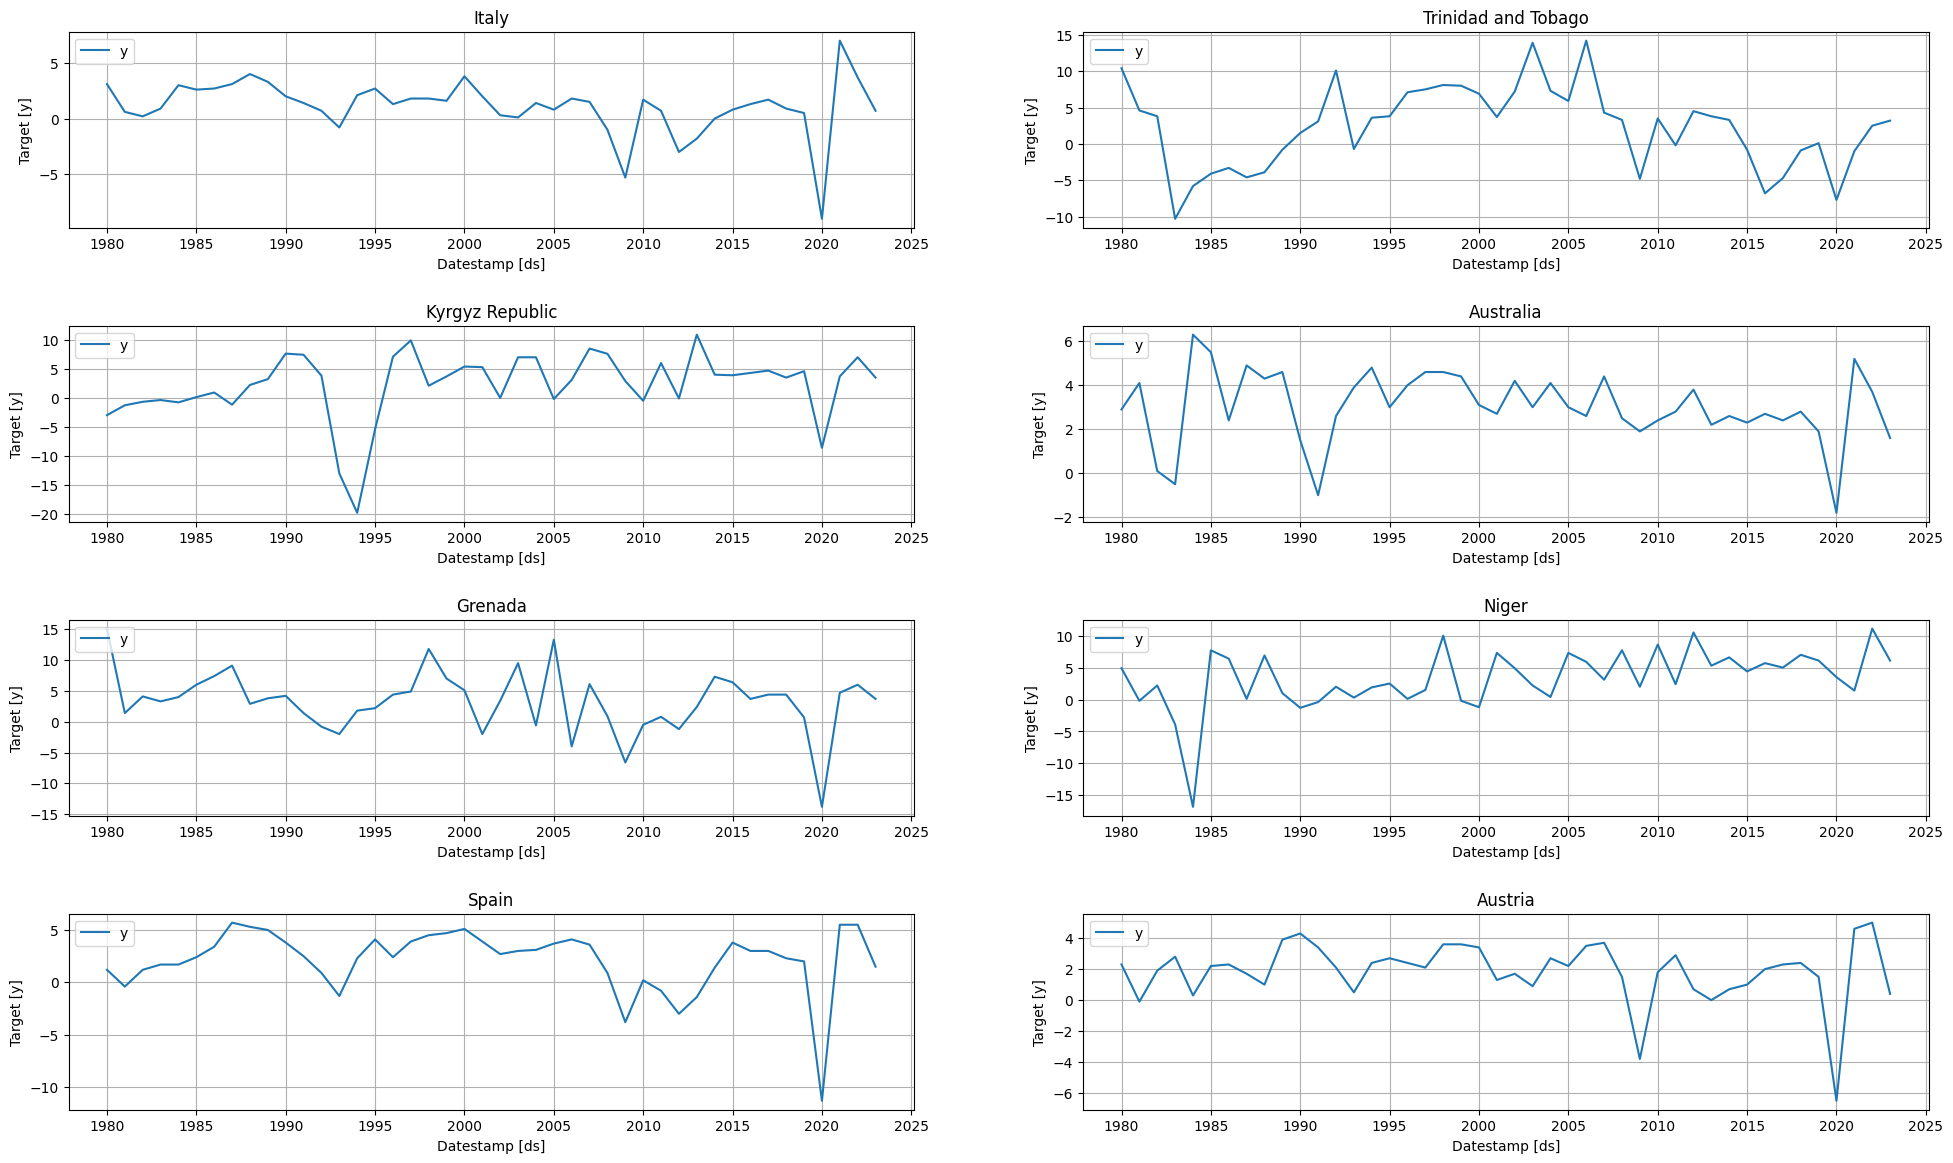

In [39]:
StatsForecast.plot(Y_df, engine="matplotlib")

## Treinamento dos modelos

#### Modelos utilizados

Dentro do catálogo de modelos disponíveis na biblioteca statsforecast, a escolha dos modelos se baseia em um caráter exploratório de difentes classes que levam ou não em consideração padrões de sazonalidades ou tendências, visto que todos serão aplicados a cada uma das séries e, como observado no EDA, existem séries bastantes ruidosas e outras com caráter mais suave e com possíveis tendências.

- AutoArima: Modelo que se ajusta de forma autoática aos parâmetros de um modelo ARIMA (Auto-regressive Integraded Moving Average), combinando componentes autoregressivos e de média móvel para realizar a captura de tendências e autocorrelações dentro da série.

- HistoricAverage: Modelo que pode ser utilizado como basline, se baseia na média histórica da série temporal para produzir previsões. Não considera nenhum tipo de variação dos dados e pode ser utilizado em séries muito ruidosas e sem padrão aparente. Podendo se encaixar bem algumas séries jaqui obseervadas

- RandomWalkWithDrift: Modelo que assume que o valor futuro será igual ao valor atual mais um termo de tendênciam tendo uma evolução "aleatória", com alguma tendência de aumento ou diminuição ao longo do tempo. também não leva em conta tendências ou sazonalidades nos dados.

- DynamicOptimizedTheta: Modelo que propõe a decomposição da série temporal em duas ou mais "linhas theta" que realçam os movimentos de curto e longo prazo nos dados. A seleção dessas linhas são enão otimizadas com base em diferentes esquemas de validação onde a precisão fora da amostra dos candidatos é medida.



In [40]:
models = [
    AutoARIMA(season_length=1),
    HistoricAverage(),
    DynamicOptimizedTheta(season_length=1),
    RandomWalkWithDrift(),
]

- Aqui instaciamos nossos modelos e setamos a frquência como anual (Y). A predição será feita para 5 anos posteriores "h=5" com um nível de confianã de 90%

In [41]:
sf = StatsForecast(
    df=Y_df, 
    models=models,
    freq='Y', 
    n_jobs=-1,
)

In [42]:
forecasts_df = sf.forecast(h=5, level=[90])

In [48]:
forecasts_df

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90,RWD,RWD-lo-90,RWD-hi-90
unique_id,,,,,,,,,,,,,
ASEAN-5,2024,4.032939,-1.441612,9.507491,5.027273,-0.223970,10.278517,4.168433,-0.781249,10.411557,4.425581,-1.705124,10.556287
ASEAN-5,2025,4.022299,-1.485466,9.530065,5.027273,-0.223970,10.278517,4.166541,-1.536248,8.853304,4.351163,-4.416934,13.119261
ASEAN-5,2026,4.011687,-1.528920,9.552295,5.027273,-0.223970,10.278517,4.164701,-2.659704,9.395596,4.276744,-6.580601,15.134090
ASEAN-5,2027,4.001103,-1.571981,9.574187,5.027273,-0.223970,10.278517,4.162909,-1.501479,8.841671,4.202326,-8.470196,16.874847
ASEAN-5,2028,3.990547,-1.614656,9.595750,5.027273,-0.223970,10.278517,4.161162,-0.598724,9.991510,4.127907,-10.190336,18.446150
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe,2024,5.793363,-2.772011,14.358737,-0.136174,-11.300291,11.027943,2.692803,-7.141351,15.096803,2.559108,-8.371763,13.489980
Zimbabwe,2025,0.000000,-11.979345,11.979345,-0.136174,-11.300291,11.027943,2.692803,-10.266914,14.384515,2.618217,-13.015048,18.251482
Zimbabwe,2026,0.000000,-11.979345,11.979345,-0.136174,-11.300291,11.027943,2.692803,-14.058834,16.755293,2.677325,-16.681009,22.035660


#### Visualização de predição para algumas séries aleatórias

- Comparação entre todos os modelos

[08/31/23 17:33:41] WARNING  /home/lineker/indicium/seara_demand_forecast/venv/lib/python3.10/site- ]8;id=305595;file:///usr/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=972879;file:///usr/lib/python3.10/warnings.py#109\109]8;;\
                             packages/statsforecast/core.py:1240: MatplotlibDeprecationWarning: The                
                             get_cmap function was deprecated in Matplotlib 3.7 and will be removed                
                             two minor releases later. Use ``matplotlib.colormaps[name]`` or                       
                             ``matplotlib.colormaps.get_cmap(obj)`` instead.                                       
                               colors = plt.cm.get_cmap("tab20b", len(models))                                     
                                                                                                                   

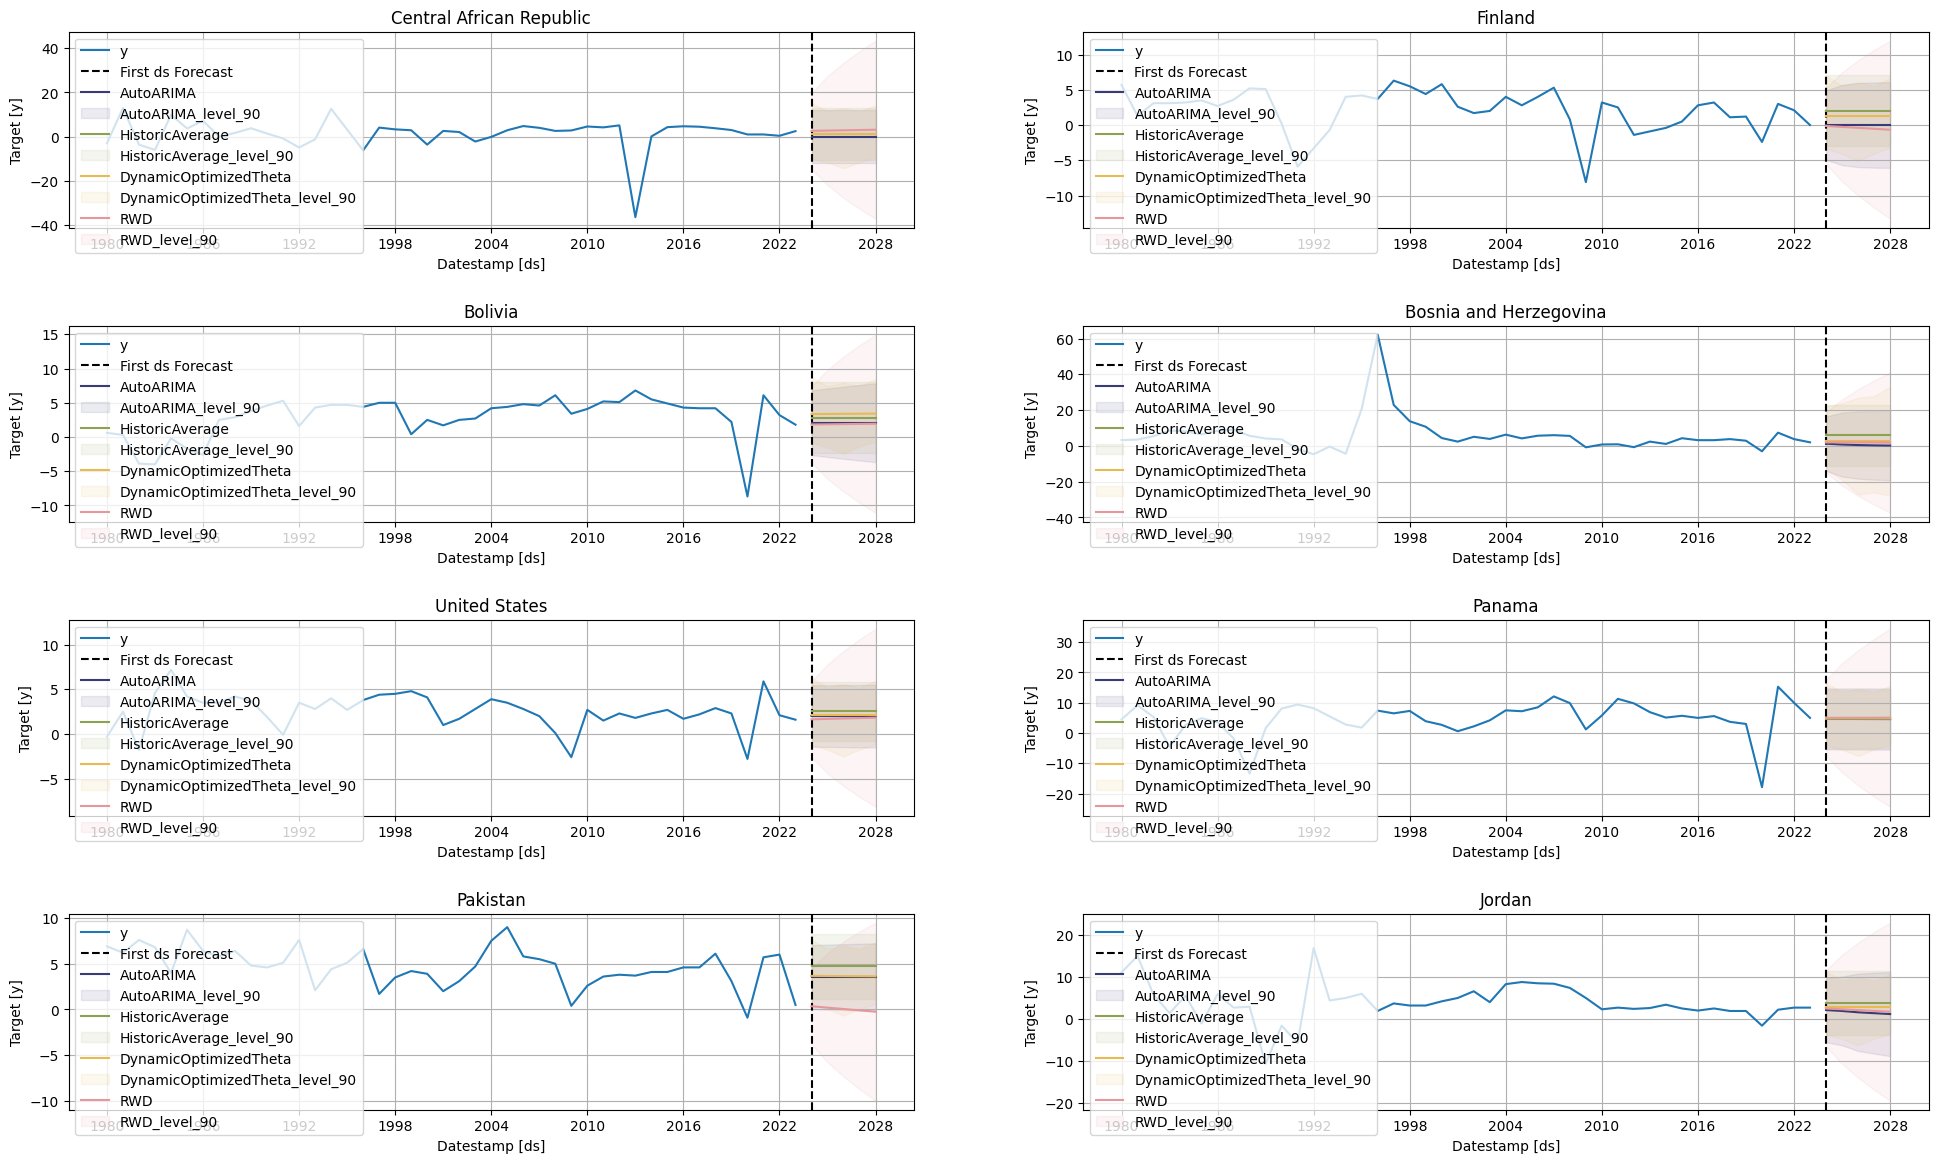

In [17]:
sf.plot(Y_df,forecasts_df, engine="matplotlib")

- Comparação do Autoarima com nosso modelo baseline que não leva em consideração padrões nos dados

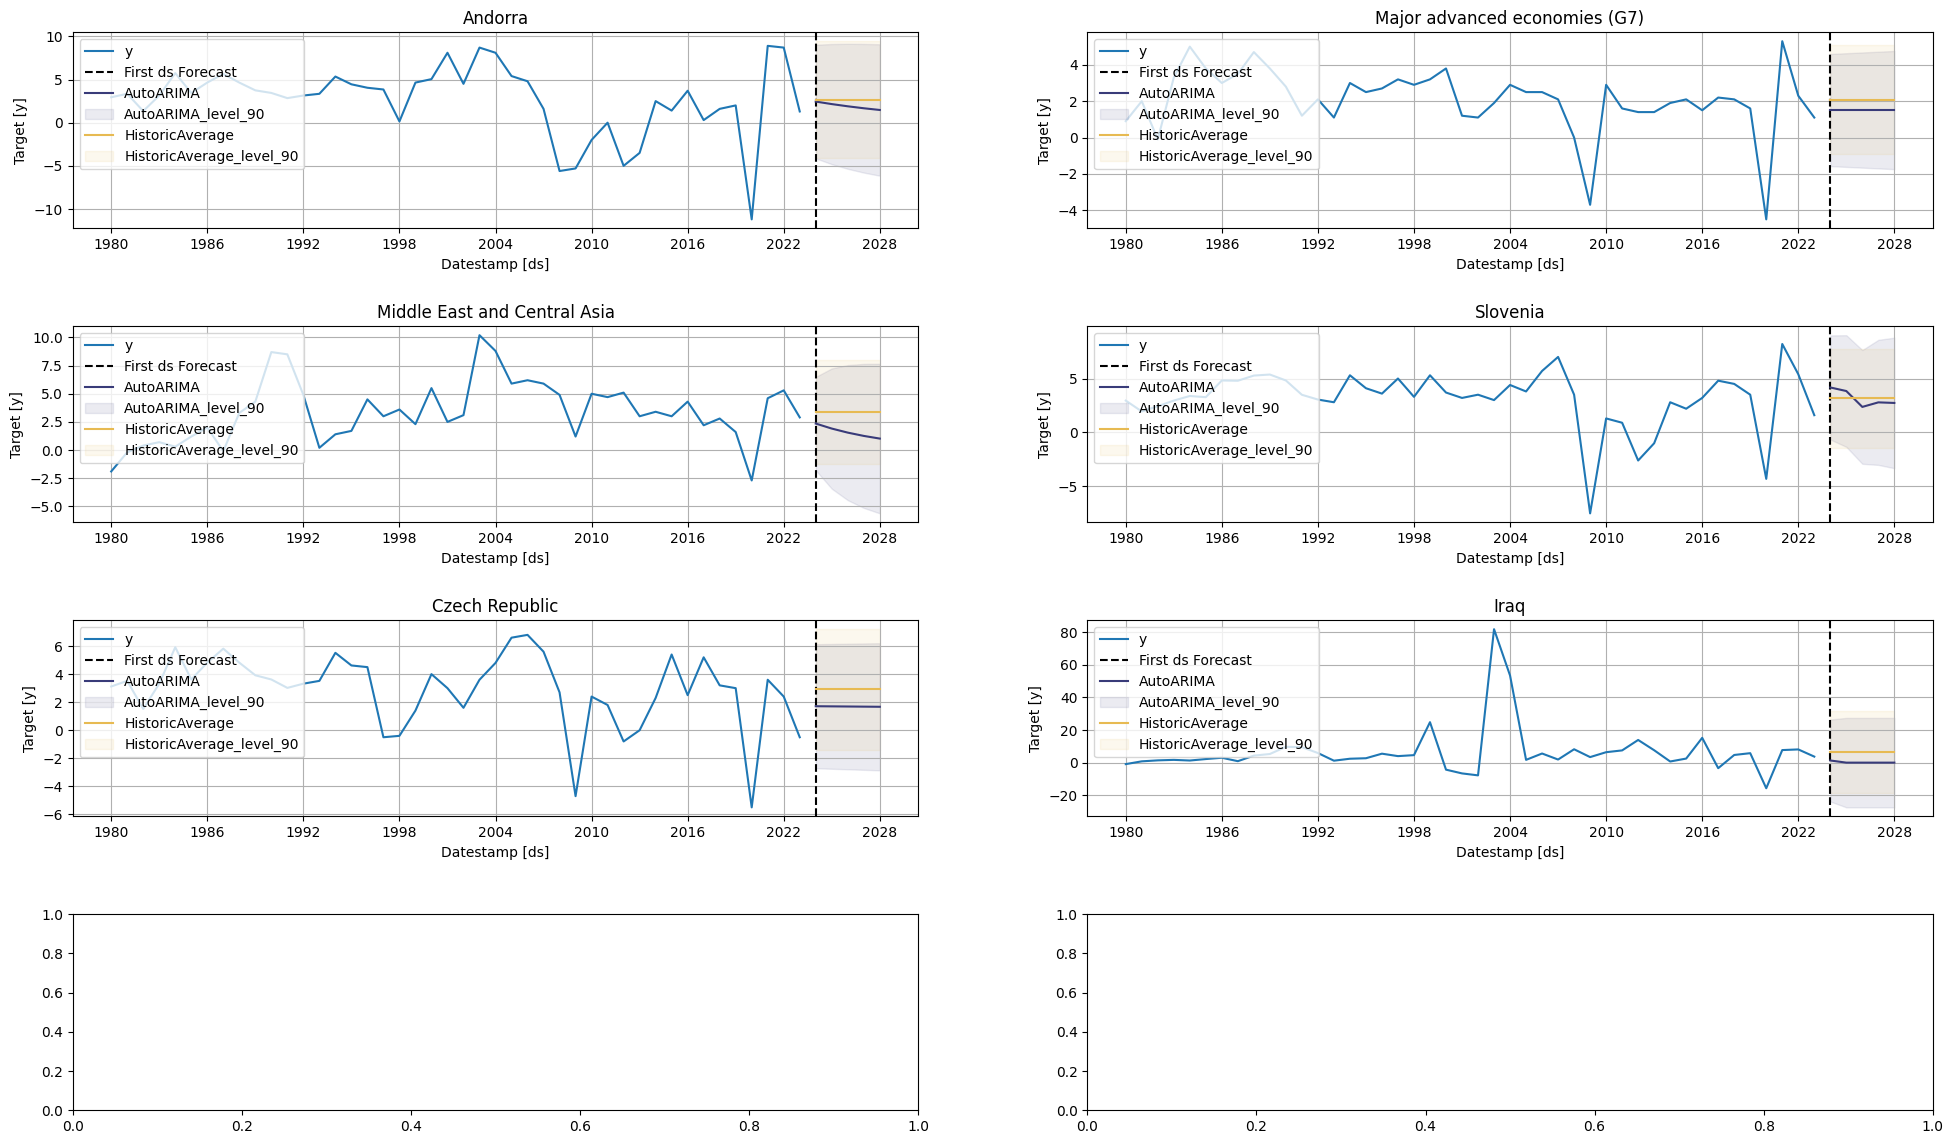

In [24]:
sf.plot(Y_df, forecasts_df, 
        models=["AutoARIMA", "HistoricAverage"], 
        unique_ids=["Andorra", 
                    "Czech Republic", 
                    "Slovenia", 
                    "Iraq", 
                    "Middle East and Central Asia", 
                    "Major advanced economies (G7)"], 
        level=[90], engine="matplotlib")

- Com as poucas observções selecionadas, podemos notar como modelo de médias histórcas tende a fazer previsões em grande parte superiores ao modelo de AutoArima.

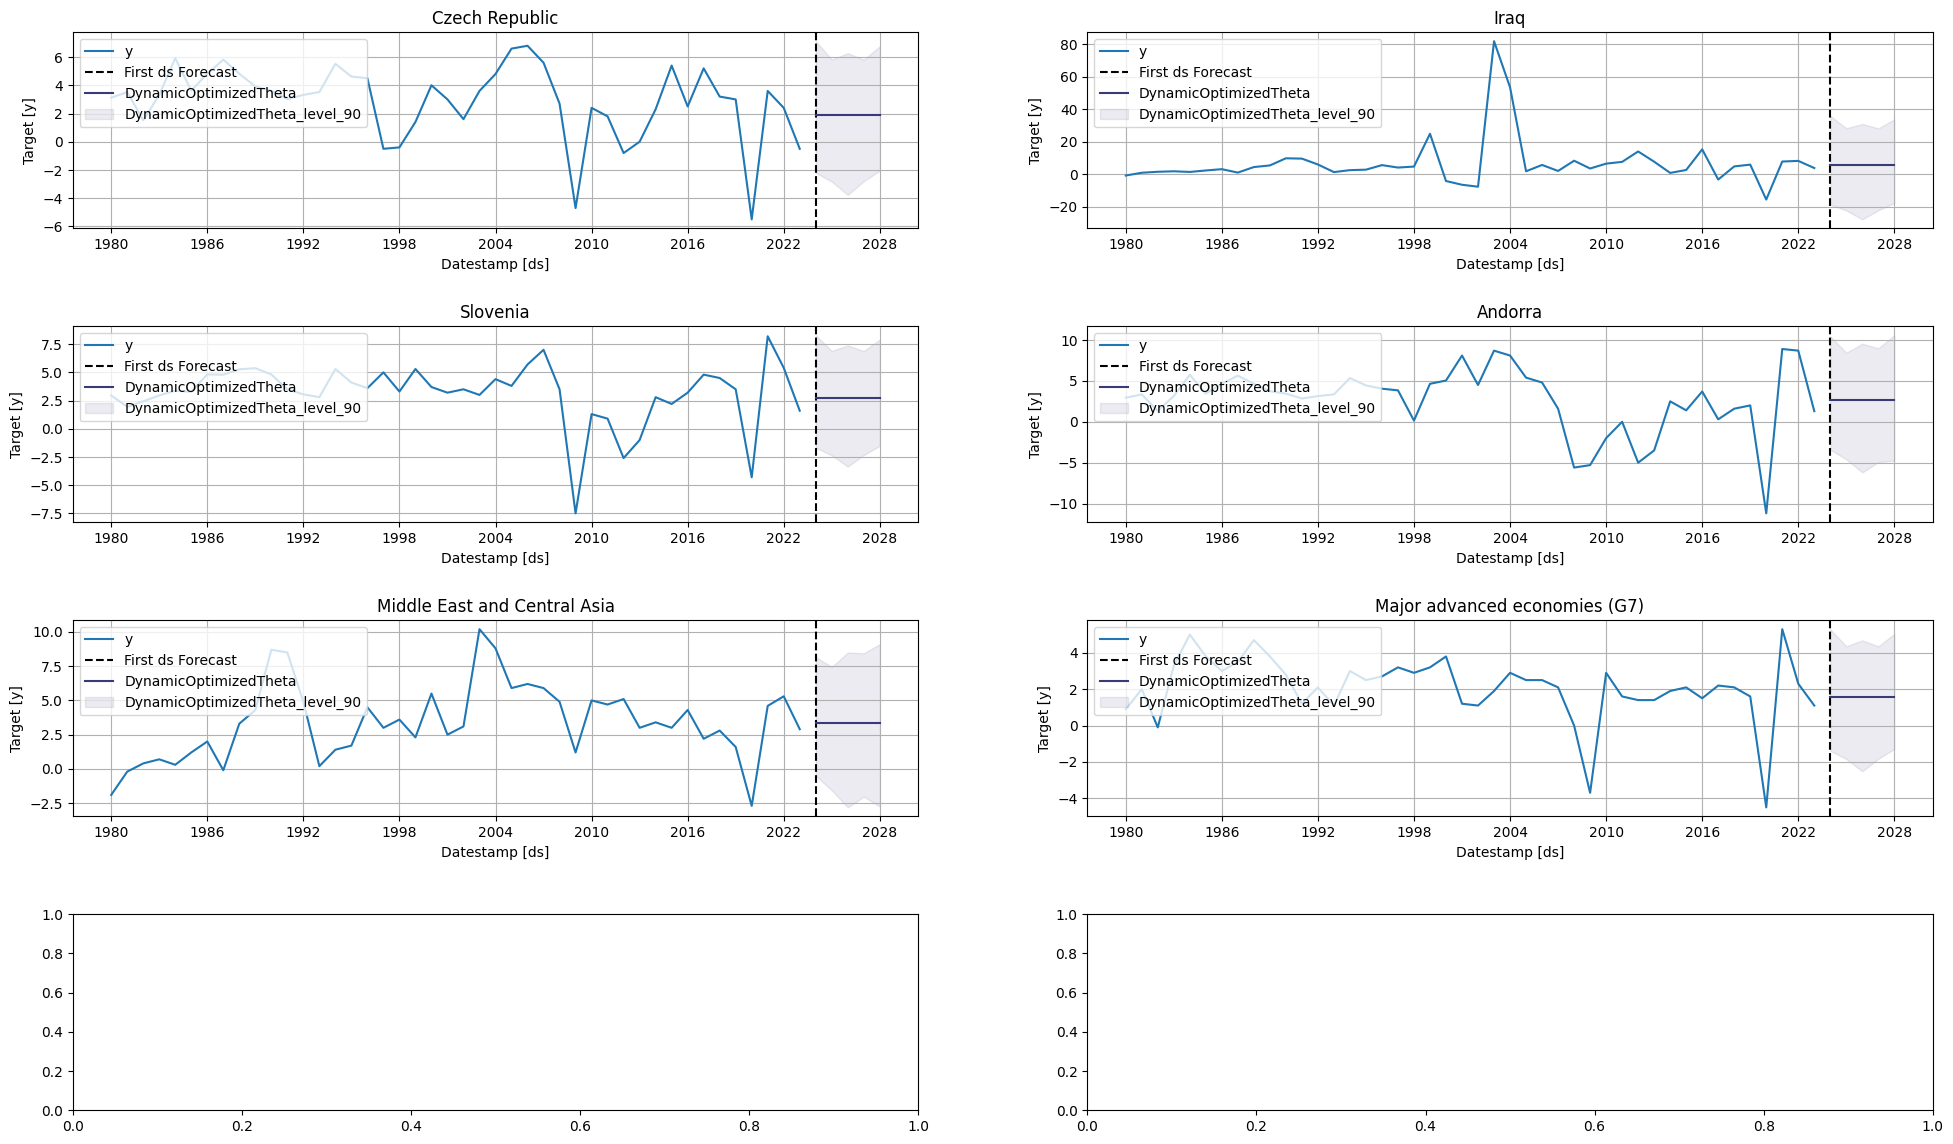

In [25]:
sf.plot(Y_df, forecasts_df, 
        models=["DynamicOptimizedTheta", "RandomWalkWithDrift"], 
        unique_ids=["Andorra", 
                    "Czech Republic", 
                    "Slovenia", 
                    "Iraq", 
                    "Middle East and Central Asia", 
                    "Major advanced economies (G7)"], 
        level=[90], engine="matplotlib")

- Para o mesmo sample de séries selecionadas,, ambos os modelos de Theta e RandomWalkWithDrift se assemelham bastante, apesar do RandomWalk não levar em consideração algumas tendências ou sazonalidades, seu caráter de evolução "aleatória" pode ser um bom encaixe ao comportamento padrão da evolução econômica dos países.

### Cross Validation

- Para a etapa de validação cruzada, serão considerados os seguintes argumentos:

    - h=5: Reprenta o número de prediç~eos futuras que desejamos realizarm, logo de 2023 à 2028.
    - step_size=8: Passo entre cada janela ou com que frequência será executado o processo de previsão.
    - n_windows: Número de janelas utilizadas para validação cruzada, ou, número de previsões do passado que desejamos validar.
    
Assim iremos validar a performance de cada modelo para os últimos 8 anos, predizendo à cada quarto ano.

In [44]:
crossvaldation_df = sf.cross_validation(
    df=Y_df,
    h=5,
    step_size=4,
    n_windows=8
  )

In [46]:
crossvaldation_df.head(10)

,ds,cutoff,y,AutoARIMA,HistoricAverage,DynamicOptimizedTheta,RWD
unique_id,,,,,,,
ASEAN-5,1991,1990,7.5,8.390727,6.127272,8.765312,8.800000
ASEAN-5,1992,1990,6.6,8.092449,6.127272,8.765312,8.900000
ASEAN-5,1993,1990,7.9,7.804774,6.127272,8.765312,9.000000
ASEAN-5,1994,1990,7.7,7.527326,6.127272,8.765312,9.099999
ASEAN-5,1995,1990,7.9,7.259740,6.127272,8.765312,9.200000
ASEAN-5,1995,1994,7.9,7.700000,6.473333,7.708204,7.700000
ASEAN-5,1996,1994,7.4,7.700000,6.473333,7.708204,7.700000
ASEAN-5,1997,1994,3.8,7.700000,6.473333,7.708204,7.700000
ASEAN-5,1998,1994,-8.8,7.700000,6.473333,7.708204,7.700000


- Aqui, realizaremos nossa validação através das métricas já descritas acima

In [49]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [50]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mape)
evaluation_df.head()

,AutoARIMA,HistoricAverage,DynamicOptimizedTheta,RWD,best_model
unique_id,,,,,
ASEAN-5,0.662875,0.351010,0.737037,0.859031,HistoricAverage
Advanced economies,0.609556,0.628913,0.570622,0.800293,DynamicOptimizedTheta
Afghanistan,1.544520,0.923061,1.508979,1.173378,HistoricAverage
Africa (Region),1.216608,1.453191,1.339378,1.241738,AutoARIMA
Albania,0.916174,0.699764,0.804028,0.812681,HistoricAverage


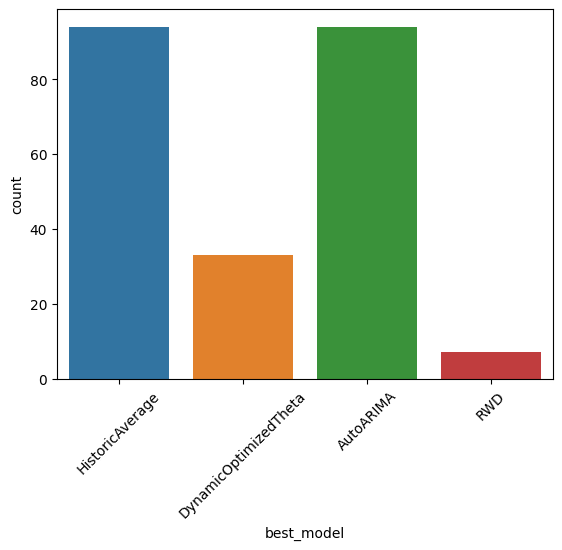

In [57]:
sns.countplot(data=evaluation_df, x="best_model")
plt.xticks(rotation=45)
plt.show()

In [59]:
evaluation_df["best_model"].value_counts().to_frame()

,count
best_model,
HistoricAverage,94
AutoARIMA,94
DynamicOptimizedTheta,33
RWD,7


- Observamos aqui um empate entre os modelos AutoArima e Média histórica

[08/31/23 18:25:32] WARNING  /home/lineker/indicium/seara_demand_forecast/venv/lib/python3.10/site- ]8;id=467836;file:///usr/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=565347;file:///usr/lib/python3.10/warnings.py#109\109]8;;\
                             packages/statsforecast/core.py:1240: MatplotlibDeprecationWarning: The                
                             get_cmap function was deprecated in Matplotlib 3.7 and will be removed                
                             two minor releases later. Use ``matplotlib.colormaps[name]`` or                       
                             ``matplotlib.colormaps.get_cmap(obj)`` instead.                                       
                               colors = plt.cm.get_cmap("tab20b", len(models))                                     
                                                                                                                   

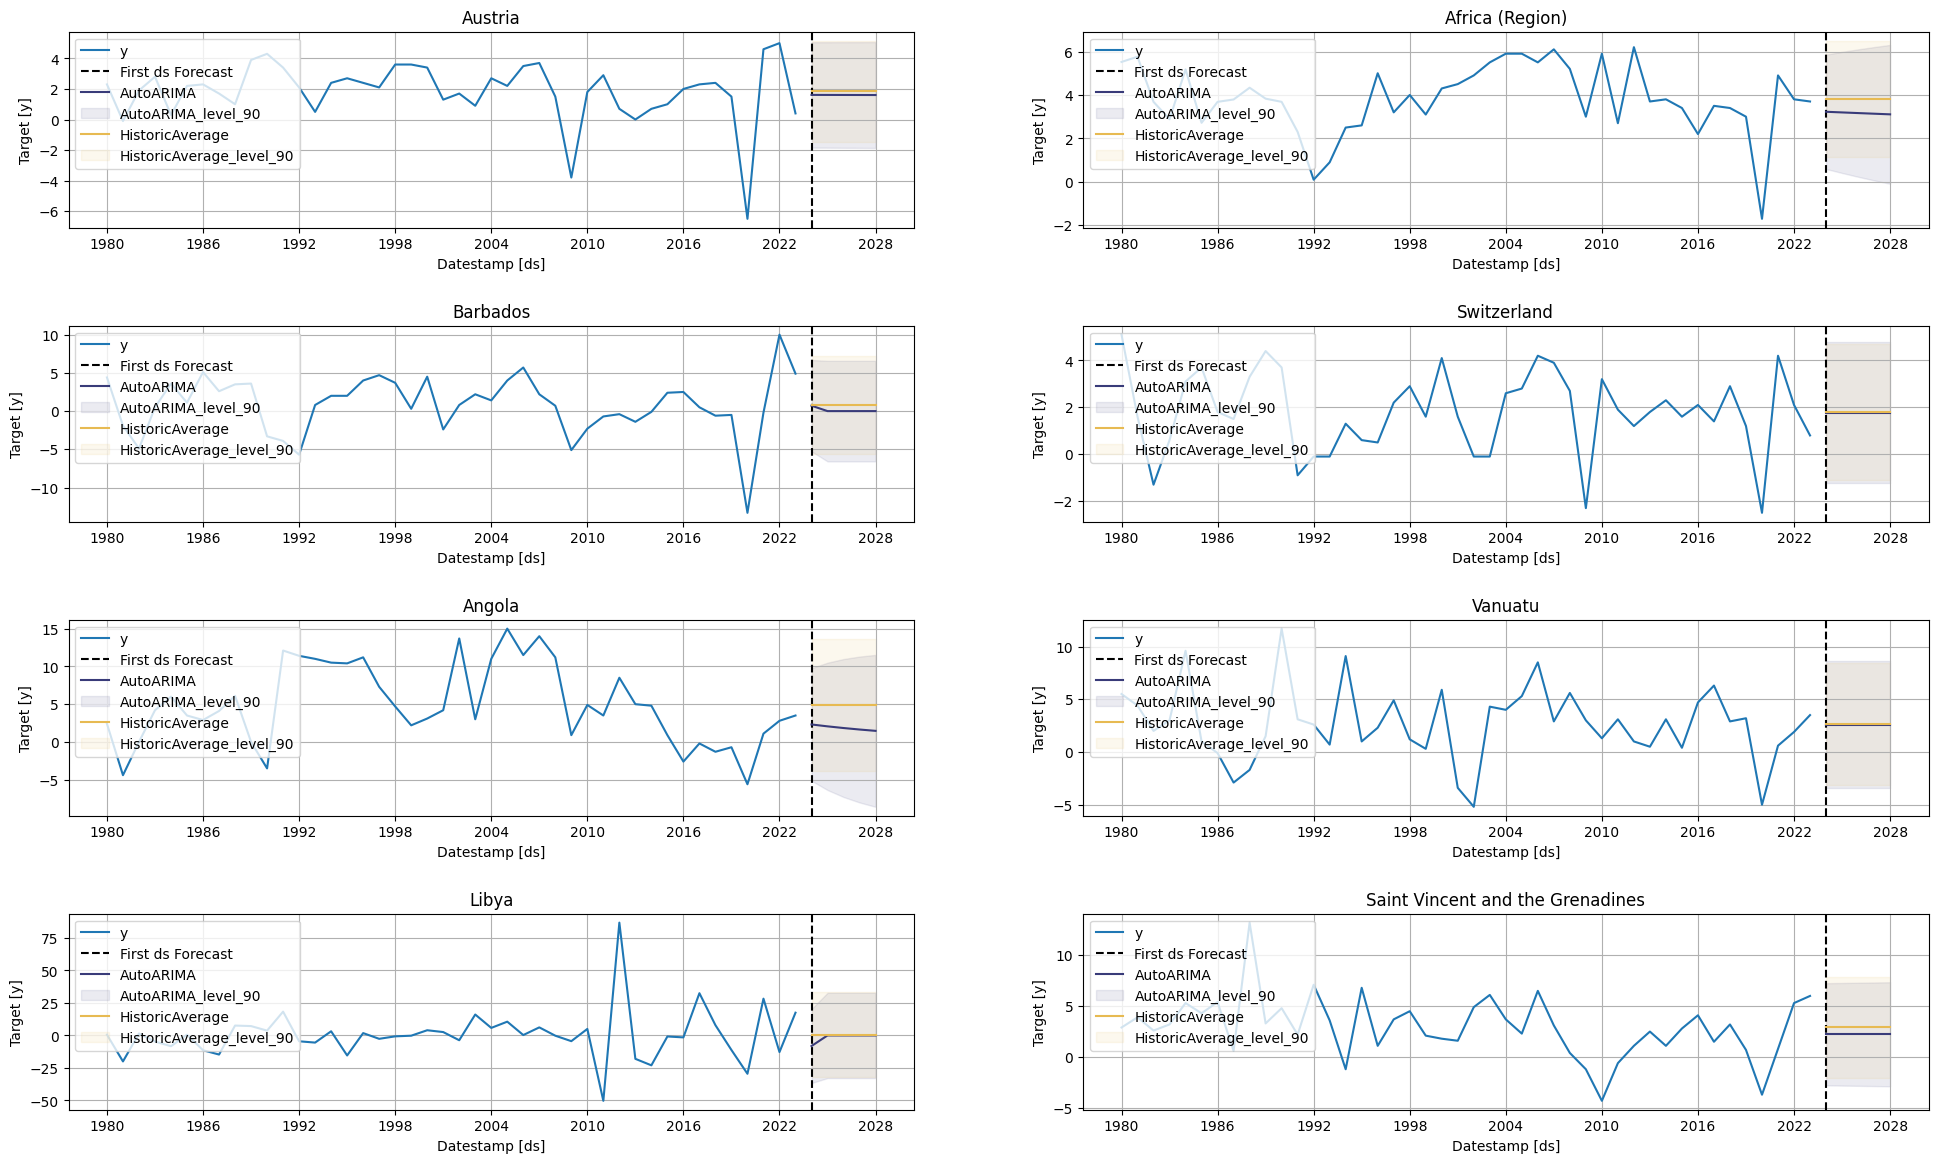

In [62]:
seasonal_ids = evaluation_df.query('best_model == "AutoARIMA"').index
sf.plot(Y_df,forecasts_df, unique_ids=seasonal_ids, models=["AutoARIMA","HistoricAverage"], engine="matplotlib")

- Aqui faremos a seleção do melhor modelo para cada série.

In [64]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index('ds', append=True).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df = df.reset_index(level=1)
    return df

In [93]:
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)
prod_forecasts_df.head()

model,ds,best_model,best_model-hi-90,best_model-lo-90
unique_id,,,,
ASEAN-5,2024,5.027273,10.278517,-0.22397
ASEAN-5,2025,5.027273,10.278517,-0.22397
ASEAN-5,2026,5.027273,10.278517,-0.22397
ASEAN-5,2027,5.027273,10.278517,-0.22397
ASEAN-5,2028,5.027273,10.278517,-0.22397


[08/31/23 18:32:18] WARNING  /home/lineker/indicium/seara_demand_forecast/venv/lib/python3.10/site- ]8;id=787643;file:///usr/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=434492;file:///usr/lib/python3.10/warnings.py#109\109]8;;\
                             packages/statsforecast/core.py:1240: MatplotlibDeprecationWarning: The                
                             get_cmap function was deprecated in Matplotlib 3.7 and will be removed                
                             two minor releases later. Use ``matplotlib.colormaps[name]`` or                       
                             ``matplotlib.colormaps.get_cmap(obj)`` instead.                                       
                               colors = plt.cm.get_cmap("tab20b", len(models))                                     
                                                                                                                   

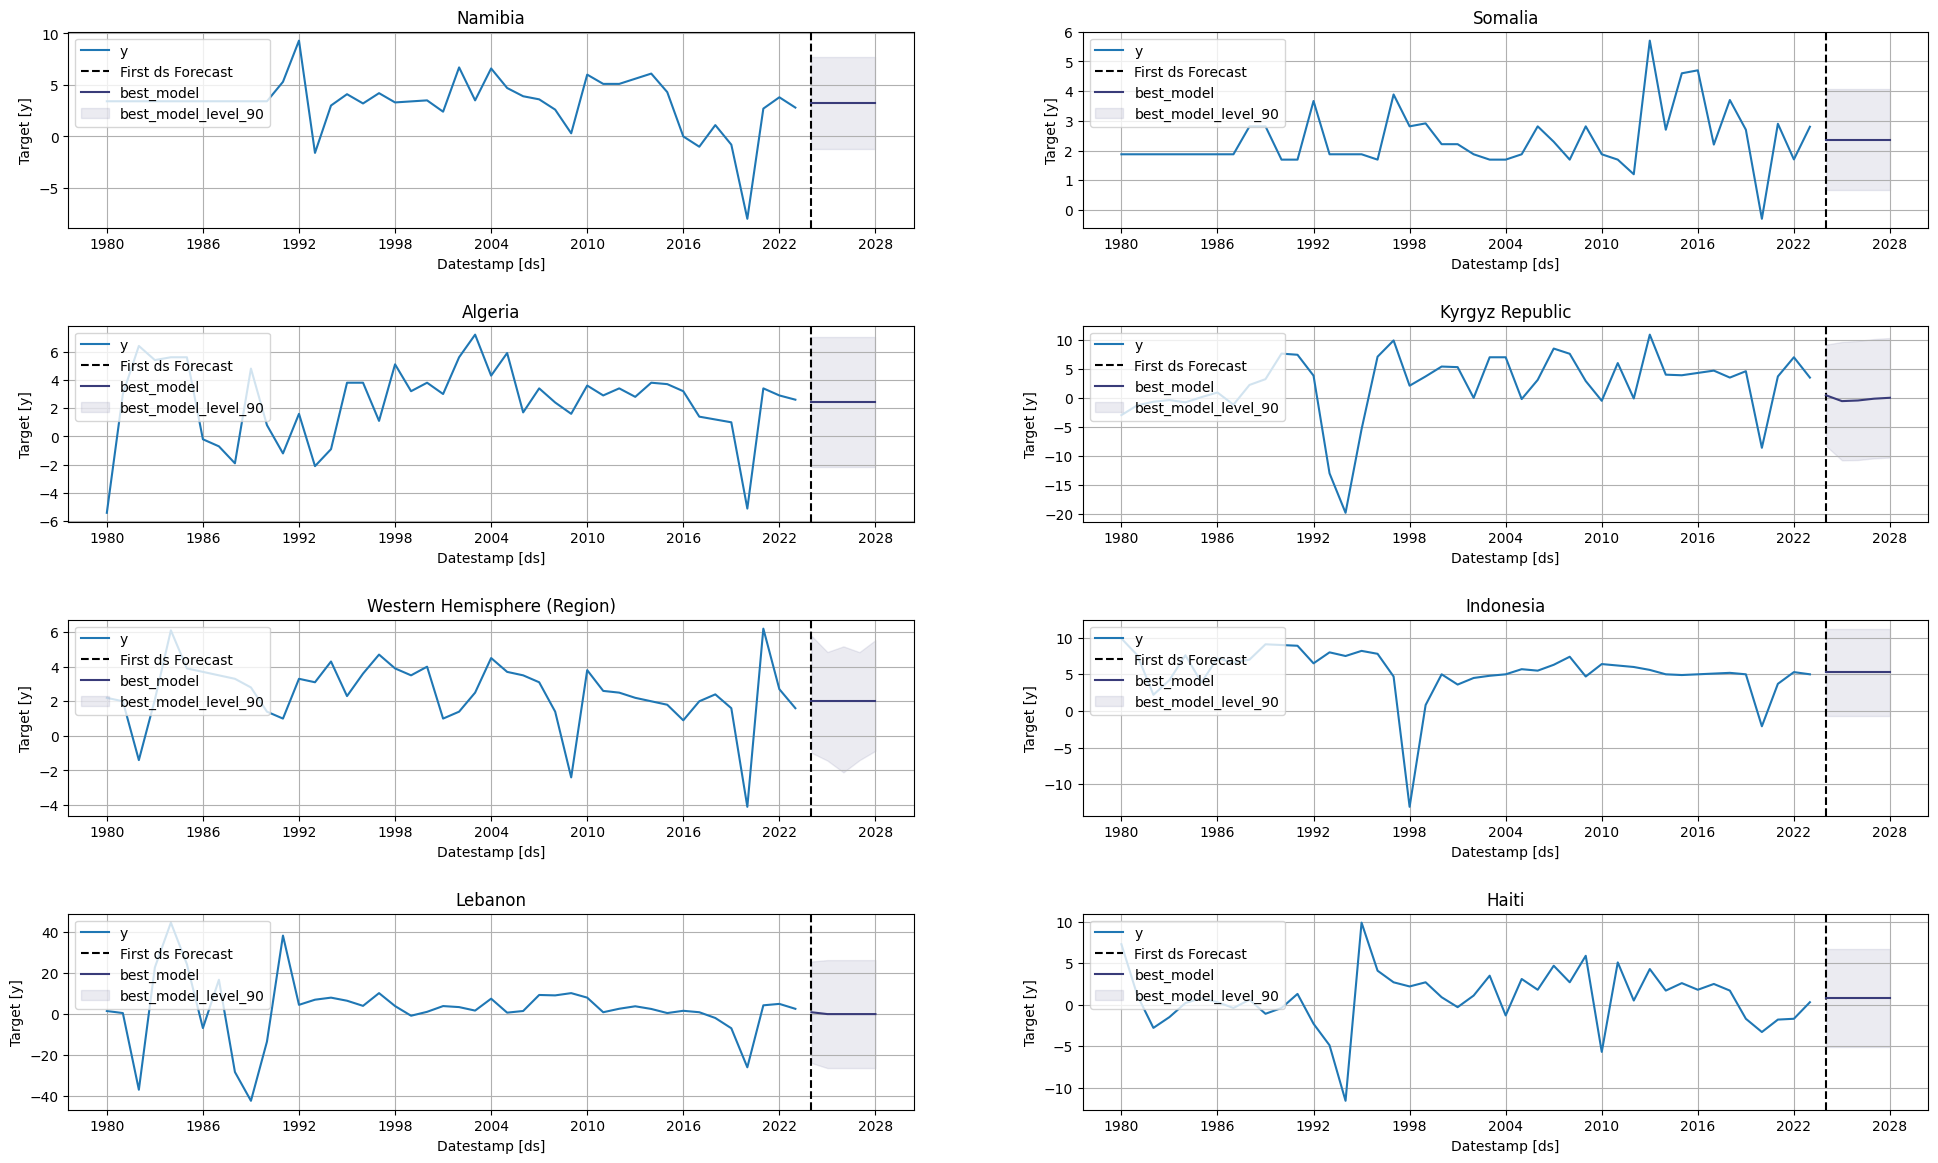

In [75]:
sf.plot(Y_df, prod_forecasts_df, level=[90], engine="matplotlib")

In [76]:
prod_forecasts_df.head()

model,ds,best_model,best_model-hi-90,best_model-lo-90
unique_id,,,,
ASEAN-5,2024,5.027273,10.278517,-0.22397
ASEAN-5,2025,5.027273,10.278517,-0.22397
ASEAN-5,2026,5.027273,10.278517,-0.22397
ASEAN-5,2027,5.027273,10.278517,-0.22397
ASEAN-5,2028,5.027273,10.278517,-0.22397


## Reorgamização dos dados

- Para fins de comparação, aqui reajustaremos nosso dataset original com as predições originais de 2023 à 2028 com as predições aqui realizadas

In [94]:
prod_forecasts_df = prod_forecasts_df[["ds", "best_model"]].reset_index()
prod_forecasts_df = prod_forecasts_df.rename(columns={"best_model": "y"})
prod_forecasts_df.columns.name = None
prod_forecasts_df

,unique_id,ds,y
0,ASEAN-5,2024,5.027273
1,ASEAN-5,2025,5.027273
2,ASEAN-5,2026,5.027273
3,ASEAN-5,2027,5.027273
4,ASEAN-5,2028,5.027273
...,...,...,...
1135,Zimbabwe,2024,-0.136174
1136,Zimbabwe,2025,-0.136174
1137,Zimbabwe,2026,-0.136174
1138,Zimbabwe,2027,-0.136174


In [99]:
full_df_with_forecast = pd.concat([Y_df, prod_forecasts_df])
full_df_with_forecast

,ds,unique_id,y
0,1980,Afghanistan,0.123529
1,1981,Afghanistan,1.823529
2,1982,Afghanistan,2.423529
3,1983,Afghanistan,2.723529
4,1984,Afghanistan,2.323529
...,...,...,...
1135,2024,Zimbabwe,-0.136174
1136,2025,Zimbabwe,-0.136174
1137,2026,Zimbabwe,-0.136174
1138,2027,Zimbabwe,-0.136174


In [100]:
full_df_with_forecast = pd.pivot(full_df_with_forecast, 
                                 columns="unique_id", 
                                 values="y", 
                                 index="ds").reset_index()
full_df_with_forecast.columns.name = None
full_df_with_forecast

,ds,ASEAN-5,Advanced economies,Afghanistan,Africa (Region),Albania,Algeria,Andorra,Angola,Antigua and Barbuda,...,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Western Europe,Western Hemisphere (Region),World,Yemen,Zambia,Zimbabwe
0,1980,7.700000,1.300000,0.123529,5.519744,2.700000,-5.400000,2.945455,2.400000,8.200000,...,5.500000,-4.900000,-3.500000,-1.146429,1.600000,2.200000,2.100000,-4.36250,3.900000,-0.041667
1,1981,6.500000,2.000000,1.823529,5.759993,5.700000,3.000000,3.345455,-4.400000,3.800000,...,4.400000,-1.300000,5.800000,0.553571,0.300000,2.000000,1.900000,-2.66250,6.600000,-0.041667
2,1982,3.800000,0.200000,2.423529,3.683795,2.900000,6.400000,1.345455,0.000000,-0.100000,...,2.000000,2.600000,8.200000,1.153571,0.700000,-1.400000,0.700000,-2.06250,-2.900000,-0.041667
3,1983,4.500000,3.200000,2.723529,2.883331,1.100000,5.400000,3.145455,4.200000,5.400000,...,3.000000,-9.900000,7.100000,1.453571,1.700000,2.100000,2.600000,-1.76250,-1.100000,-0.041667
4,1984,4.600000,4.800000,2.323529,5.177041,2.000000,5.600000,5.745455,6.000000,10.200000,...,9.600000,5.200000,8.400000,1.053571,2.500000,6.100000,4.600000,-2.16250,-1.700000,-0.041667
5,1985,1.300000,3.700000,3.223529,2.718688,-1.500000,5.600000,3.445455,3.500000,7.600000,...,1.000000,0.900000,5.600000,1.953571,2.600000,3.900000,3.600000,-1.26250,1.200000,-0.041667
6,1986,5.200000,3.300000,4.023529,3.683795,5.600000,-0.200000,4.645455,2.900000,11.500000,...,-0.100000,6.100000,3.400000,2.753571,2.600000,3.700000,3.600000,-0.46250,1.700000,-0.041667
7,1987,6.900000,3.800000,1.923529,3.791934,-0.800000,-0.700000,5.645455,4.100000,6.600000,...,-2.900000,4.800000,2.500000,0.653571,3.000000,3.500000,3.900000,-2.56250,1.500000,-0.041667
8,1988,8.800000,4.800000,5.323529,4.334031,-1.400000,-1.900000,4.645455,6.100000,5.200000,...,-1.700000,6.500000,5.100000,4.053571,4.200000,3.300000,4.700000,0.83750,9.300000,-0.041667
9,1989,9.400000,3.900000,6.323529,3.829729,9.800000,4.800000,3.745455,0.000000,5.300000,...,1.500000,-13.900000,7.800000,5.053571,3.700000,2.800000,3.800000,1.83750,-3.700000,-0.041667


In [101]:
df

,ds,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,1980,0.123529,2.7,-5.4,2.945455,2.4,8.2,0.7,-0.04,3.795347,...,-0.8,3.3,1.417539,1.8,6.4,0.9,-1.9,3.8,3.9,2.1
1,1981,1.823529,5.7,3.0,3.345455,-4.4,3.8,-5.7,1.66,3.214077,...,-0.5,1.9,0.047214,0.1,0.9,2.0,-0.2,4.2,3.9,1.9
2,1982,2.423529,2.9,6.4,1.345455,0.0,-0.1,-3.1,2.26,3.658083,...,1.4,1.5,0.705273,0.6,-0.5,-0.1,0.4,2.2,3.9,0.7
3,1983,2.723529,1.1,5.4,3.145455,4.2,5.4,3.7,2.56,3.600038,...,4.6,1.8,1.417539,1.7,-2.8,3.3,0.7,4.0,3.9,2.6
4,1984,2.323529,2.0,5.6,5.745455,6.0,10.2,2.0,2.16,5.217868,...,4.1,4.1,2.013396,2.5,3.9,5.0,0.3,6.6,3.9,4.6
5,1985,3.223529,-1.5,5.6,3.445455,3.5,7.6,-7.0,3.06,3.363196,...,2.4,3.5,1.865688,2.2,3.2,3.8,1.2,4.3,3.9,3.6
6,1986,4.023529,5.6,-0.2,4.645455,2.9,11.5,7.1,3.86,3.429323,...,4.4,4.3,2.494110,2.7,4.3,3.0,2.0,5.5,3.9,3.6
7,1987,1.923529,-0.8,-0.7,5.645455,4.1,6.6,2.5,1.76,16.100000,...,5.0,4.0,2.606510,2.6,3.3,3.5,-0.1,6.5,3.9,3.9
8,1988,5.323529,-1.4,-1.9,4.645455,6.1,5.2,-2.0,5.16,18.600000,...,1.6,4.5,3.438710,3.8,1.1,4.7,3.3,5.5,3.9,4.7
9,1989,6.323529,9.8,4.8,3.745455,0.0,5.3,-7.0,6.16,12.100000,...,0.1,3.5,3.377801,3.6,1.1,3.8,4.3,4.6,3.9,3.8


In [106]:
y_df.head()

,Unnamed: 0,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,2024,NaN,3.3,2.6,1.5,3.7,5.4,2.0,5.0,1.2,...,2.5,4.2,1.4,1.6,2.2,1.1,3.5,2.2,4.2,3.0
1,2025,NaN,3.4,2.2,1.5,4.0,4.1,2.0,4.5,1.2,...,2.5,4.0,1.9,2.2,2.3,1.7,3.6,2.3,4.1,3.2
2,2026,NaN,3.4,2.1,1.5,4.1,2.7,2.0,4.5,1.1,...,2.4,4.0,1.7,2.0,2.6,1.8,3.6,2.3,4.2,3.2
3,2027,NaN,3.4,1.7,1.5,4.2,2.7,2.0,4.5,1.1,...,2.3,3.9,1.5,1.8,2.3,1.7,3.7,2.2,4.3,3.1
4,2028,NaN,3.4,1.8,1.5,4.2,2.7,2.0,4.5,1.1,...,2.3,3.9,1.4,1.7,2.3,1.6,3.7,2.3,4.4,3.0


In [107]:
y_df = y_df.rename(columns={"Unnamed: 0": "ds"})
y_df.head()

,ds,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,2024,NaN,3.3,2.6,1.5,3.7,5.4,2.0,5.0,1.2,...,2.5,4.2,1.4,1.6,2.2,1.1,3.5,2.2,4.2,3.0
1,2025,NaN,3.4,2.2,1.5,4.0,4.1,2.0,4.5,1.2,...,2.5,4.0,1.9,2.2,2.3,1.7,3.6,2.3,4.1,3.2
2,2026,NaN,3.4,2.1,1.5,4.1,2.7,2.0,4.5,1.1,...,2.4,4.0,1.7,2.0,2.6,1.8,3.6,2.3,4.2,3.2
3,2027,NaN,3.4,1.7,1.5,4.2,2.7,2.0,4.5,1.1,...,2.3,3.9,1.5,1.8,2.3,1.7,3.7,2.2,4.3,3.1
4,2028,NaN,3.4,1.8,1.5,4.2,2.7,2.0,4.5,1.1,...,2.3,3.9,1.4,1.7,2.3,1.6,3.7,2.3,4.4,3.0


In [108]:
full_df = pd.concat([df, y_df])
full_df

,ds,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,1980,0.123529,2.7,-5.4,2.945455,2.4,8.2,0.7,-0.04,3.795347,...,-0.8,3.3,1.417539,1.8,6.4,0.9,-1.9,3.8,3.9,2.1
1,1981,1.823529,5.7,3.0,3.345455,-4.4,3.8,-5.7,1.66,3.214077,...,-0.5,1.9,0.047214,0.1,0.9,2.0,-0.2,4.2,3.9,1.9
2,1982,2.423529,2.9,6.4,1.345455,0.0,-0.1,-3.1,2.26,3.658083,...,1.4,1.5,0.705273,0.6,-0.5,-0.1,0.4,2.2,3.9,0.7
3,1983,2.723529,1.1,5.4,3.145455,4.2,5.4,3.7,2.56,3.600038,...,4.6,1.8,1.417539,1.7,-2.8,3.3,0.7,4.0,3.9,2.6
4,1984,2.323529,2.0,5.6,5.745455,6.0,10.2,2.0,2.16,5.217868,...,4.1,4.1,2.013396,2.5,3.9,5.0,0.3,6.6,3.9,4.6
5,1985,3.223529,-1.5,5.6,3.445455,3.5,7.6,-7.0,3.06,3.363196,...,2.4,3.5,1.865688,2.2,3.2,3.8,1.2,4.3,3.9,3.6
6,1986,4.023529,5.6,-0.2,4.645455,2.9,11.5,7.1,3.86,3.429323,...,4.4,4.3,2.494110,2.7,4.3,3.0,2.0,5.5,3.9,3.6
7,1987,1.923529,-0.8,-0.7,5.645455,4.1,6.6,2.5,1.76,16.100000,...,5.0,4.0,2.606510,2.6,3.3,3.5,-0.1,6.5,3.9,3.9
8,1988,5.323529,-1.4,-1.9,4.645455,6.1,5.2,-2.0,5.16,18.600000,...,1.6,4.5,3.438710,3.8,1.1,4.7,3.3,5.5,3.9,4.7
9,1989,6.323529,9.8,4.8,3.745455,0.0,5.3,-7.0,6.16,12.100000,...,0.1,3.5,3.377801,3.6,1.1,3.8,4.3,4.6,3.9,3.8


### Plot de 5 séries para comparação entre as predições originais e realizadas

In [112]:
columns = full_df.columns.tolist()[1:]

In [113]:
columns_to_plot = np.random.choice(columns, 10)

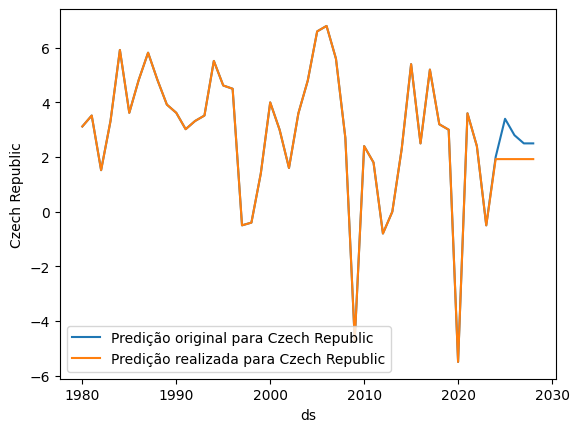

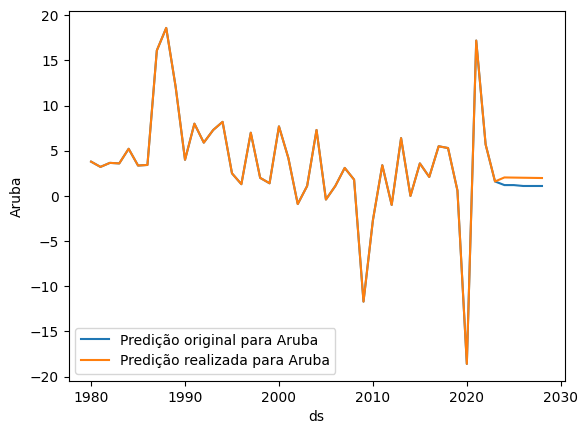

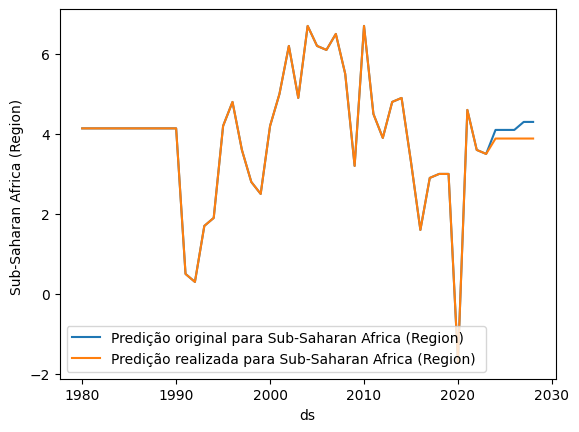

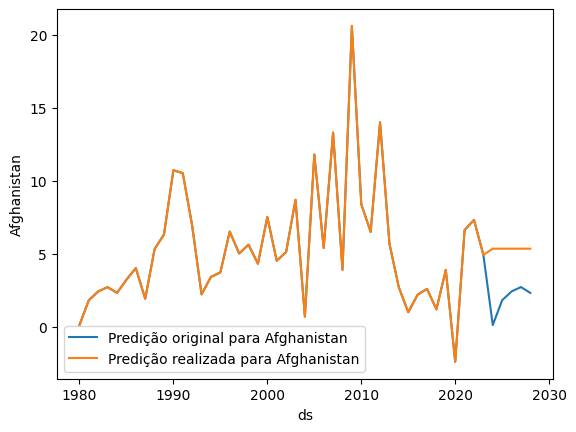

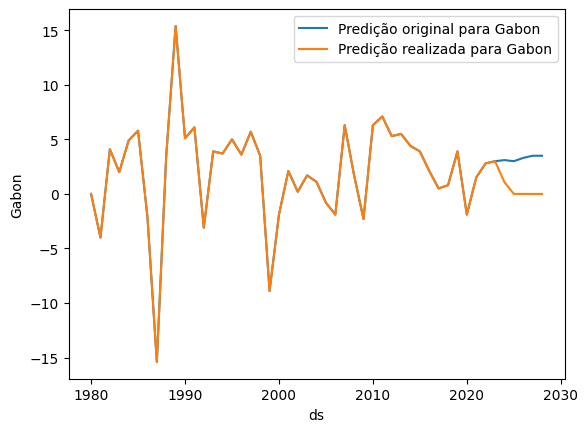

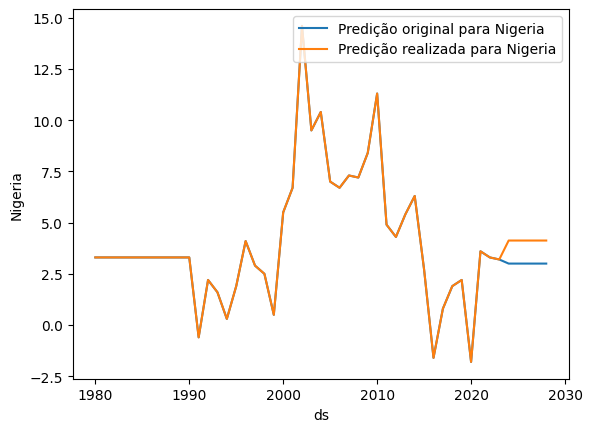

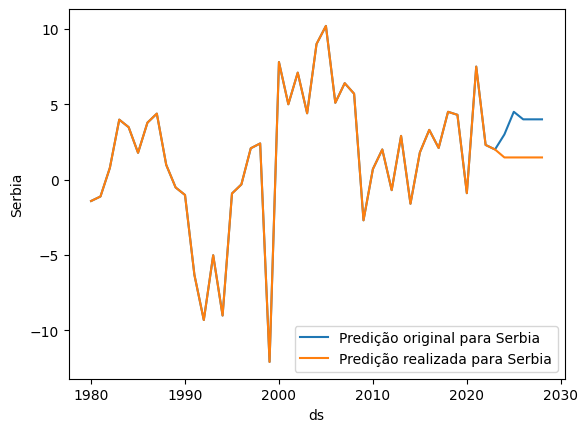

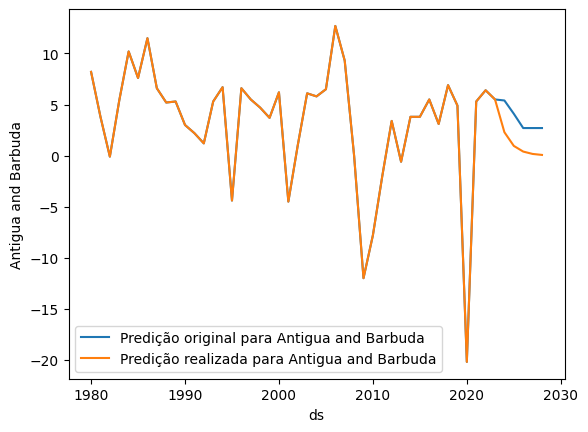

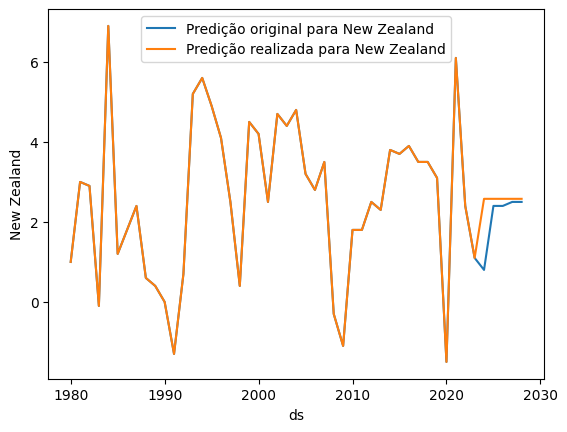

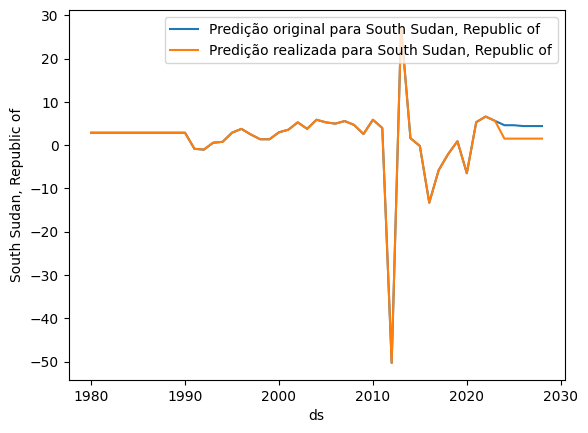

In [118]:
for column in columns_to_plot:
    plt.figure()
    sns.lineplot(data=full_df, x="ds", y=column, label=f"Predição original para {column}")
    sns.lineplot(data=full_df_with_forecast, x="ds", y=column, label=f"Predição realizada para {column}")
    plt.show()

- Pode-se observar como algumas predições se equiparam ao passo que outrs parecem bastantes diferentes.

In [120]:
full_df_with_forecast.isna().sum().sum()

0

In [121]:
full_df_with_forecast.to_csv("../Dados/predicted.csv")